# OpenCV panorama stitching
based on [this web](http://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/)
somewhere [else](http://answers.opencv.org/question/75905/stitch-images-with-opencv-3-contrib-and-python-27/)
images [here](https://github.com/jjones646/pano-stitch)


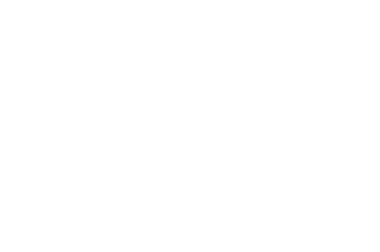

In [1]:
import numpy as np
import imutils
import cv2
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.axis("off")
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

## 0. Load 2 images to stitch

In [2]:
# load images
image_left = cv2.imread("images/scottsdale_left_01.png")
image_right = cv2.imread("images/scottsdale_right_01.png")

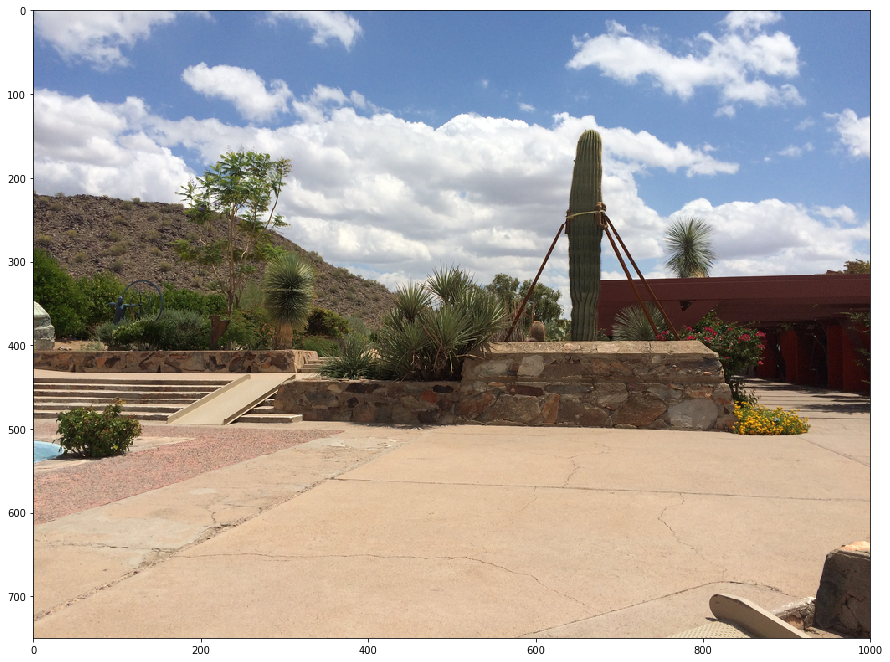

In [3]:
plt.imshow(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))

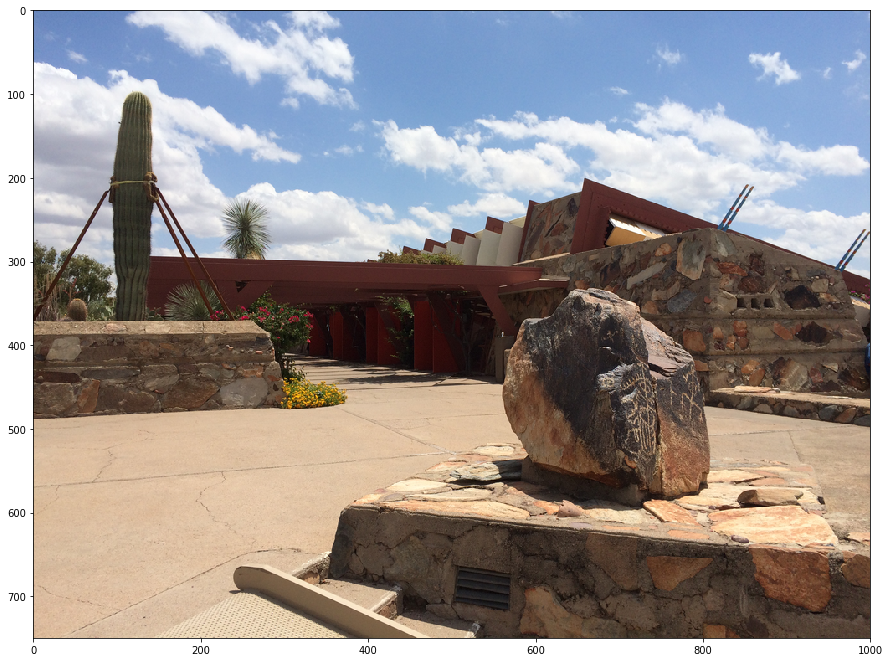

In [4]:
plt.imshow(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))

In [5]:
image_left.shape

(750, 1000, 3)

## 1. Detect and extract local invariant descriptors from the image using SIFT
[SIFT](https://sensblogs.wordpress.com/2011/08/23/quick-reviews-on-local-descriptors-sift-and-single-object-recognition-by-fei-fei-li/)
Detects keypoints and extracts local invariant descriptors, using [Difference of Gaussian](http://www.cs.utexas.edu/~grauman/courses/fall2009/papers/local_features_synthesis_draft.pdf)

In [6]:
def findKeypointsAndDescriptors(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect and extract local invariant descriptors from the image using SIFT
    sift = cv2.xfeatures2d.SIFT_create()
    (keypoints, descriptors) = sift.detectAndCompute(gray, None)
    img = None
    img = cv2.drawKeypoints(gray, keypoints, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return (keypoints, descriptors)

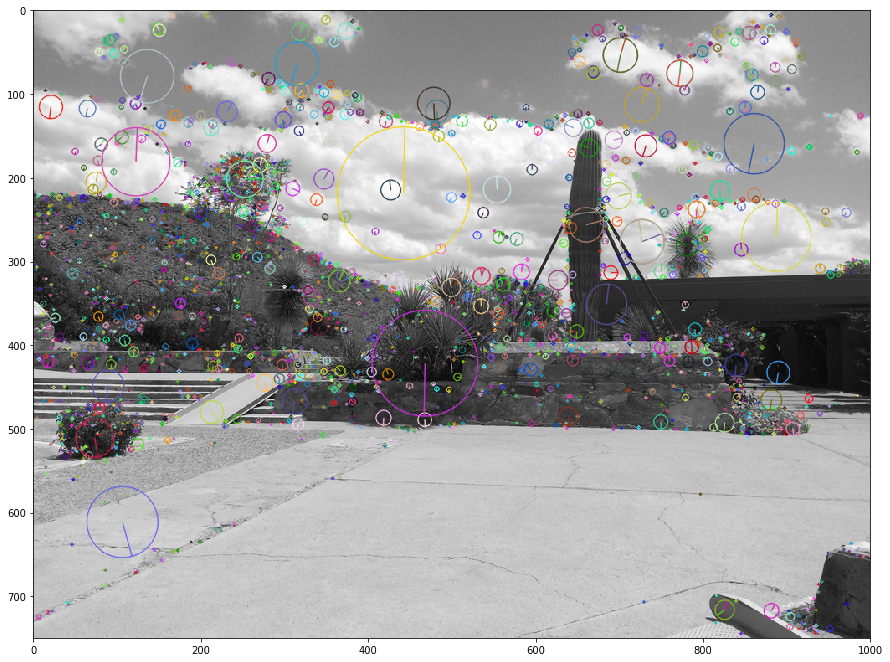

In [7]:
(keypoints_left, descriptors_left) = findKeypointsAndDescriptors(image_left)

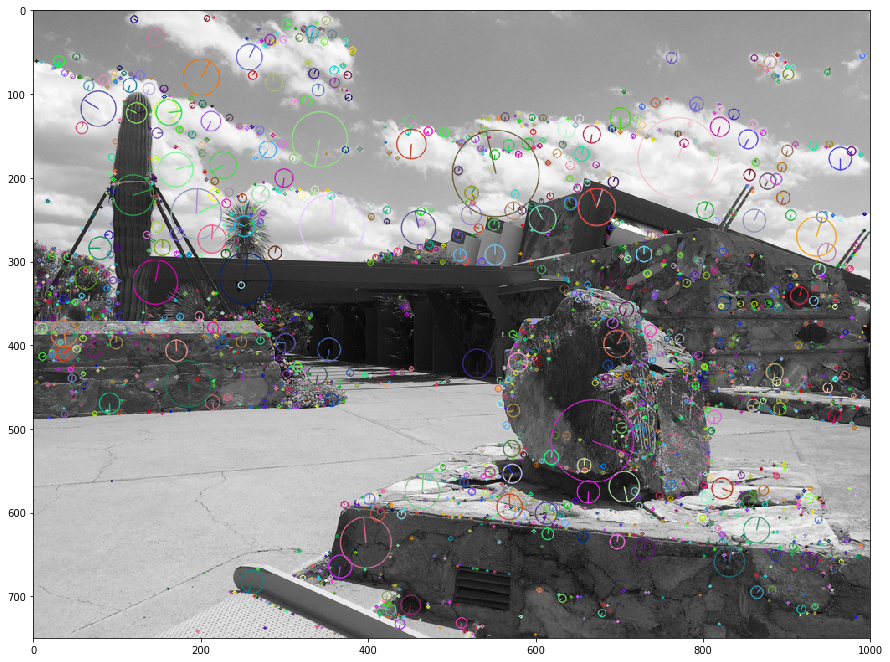

In [8]:
(keypoints_right, descriptors_right) = findKeypointsAndDescriptors(image_right)

## 2. Match descriptors between the two images
Matching features together is actually a fairly straightforward process. We simply loop over the descriptors from both images, compute the distances, and find the smallest distance for each pair of descriptors. Since this is a very common practice in computer vision, OpenCV has a built-in function called cv2.DescriptorMatcher_create  that constructs the feature matcher for us. The BruteForce  value indicates that we are going to exhaustively compute the Euclidean distance between all feature vectors from both images and find the pairs of descriptors that have the smallest distance.

The **knnMatch** call performs [k-NN matching](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) between 2 feature vector sets using k=2 in order to apply false-positive match pruning.

found 323 matches


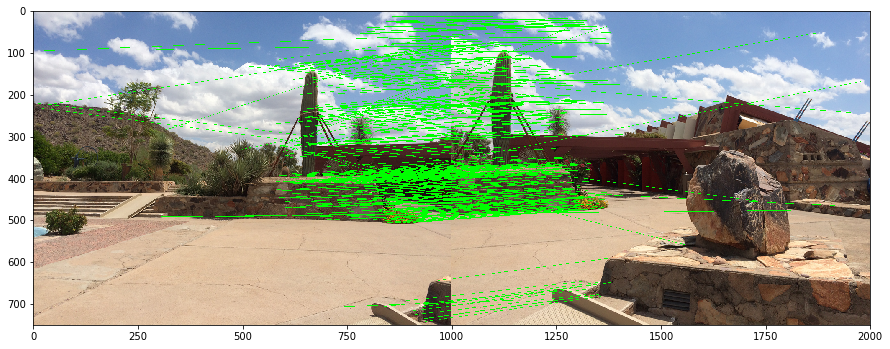

In [9]:
# convert the keypoints from KeyPoint objects to NumPy arrays
kps_left = np.float32([kp.pt for kp in keypoints_left])
kps_right = np.float32([kp.pt for kp in keypoints_right])

# compute the raw matches and initialize the list of actual matches
matches = []
matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(descriptors_left, descriptors_right, 2)

ratio = 0.75

# loop over the raw matches
for m in rawMatches:
    # ensure the distance is within a certain ratio of each other (Lowe's ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance *  ratio:
        matches.append((m[0].trainIdx, m[0].queryIdx))
        
print("found {} matches".format(len(matches)))
# construct the two sets of points
pts_left = np.float32([kps_left[i] for (_, i) in matches])
pts_right = np.float32([kps_right[i] for (i, _) in matches])

# lets draw matches
# initialize the output visualization image
(height_left, width_left) = image_left.shape[:2]
(height_right, width_right) = image_right.shape[:2]
image_matches = np.zeros((max(height_left, height_right), width_left + width_right, 3), dtype="uint8")
image_matches[0:height_left, 0:width_left] = image_left
image_matches[0:height_right, width_right:] = image_right
 
# loop over the matches
# we don't have the homography find done, therefore we don't have 'status'
# for ((trainIdx, queryIdx), s) in zip(matches, status):
for (trainIdx, queryIdx) in matches:
    # only process the match if the keypoint was successfully
    # matched
    # if s == 1:
        # draw the match
        point_left = (int(kps_left[queryIdx][0]), int(kps_left[queryIdx][1]))
        point_right = (int(kps_right[trainIdx][0]) + width_left, int(kps_right[trainIdx][1]))
        cv2.line(image_matches, point_left, point_right, (0, 255, 0), 1)

cv2.imshow('Matches', image_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))

## 3. Compute homography matrix using RANSAC Algorithm
[RANSAC Algorithm](https://en.wikipedia.org/wiki/Random_sample_consensus) and 
[Homography matrix](https://en.wikipedia.org/wiki/Homography_\%28computer_vision%29)
Computing a homography between two sets of points requires at a bare minimum an initial set of four matches. For a more reliable homography estimation, we should have substantially more than just four matched points.

Given our homography matrix H , we are now ready to stitch the two images together. First, we make a call to cv2.warpPerspective  which requires three arguments: the image we want to warp (in this case, the right image), the 3 x 3 transformation matrix ( H ), and finally the shape out of the output image. We derive the shape out of the output image by taking the sum of the widths of both images and then using the height of the second image.

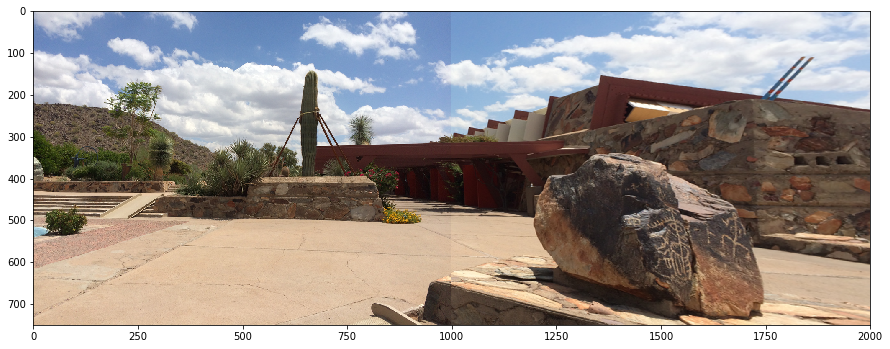

In [10]:
import sys

# computing a homography requires at least 4 matches
if len(matches) < 4:
    print("Not enough matches :(")
    sys.exit()

# compute Homography
reprojThresh = 4.0
(H, status) = cv2.findHomography(pts_right, pts_left, cv2.RANSAC, reprojThresh)

image_stitching = cv2.warpPerspective(image_right, H, (image_right.shape[1] + image_left.shape[1], image_right.shape[0]))
image_stitching[0:image_left.shape[0], 0:image_left.shape[1]] = image_left

plt.imshow(cv2.cvtColor(image_stitching, cv2.COLOR_BGR2RGB))


